In [1]:
# generate some toy regression data with noise

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();


plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["font.size"] = 20

<Figure size 432x288 with 0 Axes>

In [3]:
import corner

In [4]:
import numpy as np

In [5]:
def gen_data(x, noise_type='none', noise_sd=0, beta0=1.34, beta1=4.0):
    assert noise_type in ['none', 'random', 'secular', 'linear']
    y = beta0*x**2 * np.sin(beta1*x)
    
    # y = beta0*x + beta1
    
    if noise_type == 'random':
        noise = np.random.normal(0, noise_sd, size=y.shape)
        y = y + noise
    elif noise_type == 'secular':
        noise = np.random.normal(0, noise_sd)
        y = y + noise
    elif noise_type == 'linear':
        # heteroskedastic noise
        # the noise depends on the coordinate position x.
        # we have parameterised the standard deviation
        # of the noise model
        noise_m = noise_sd
        noise_b = 0
        noise_linear = noise_m * x + noise_b
        noise = [np.random.normal(0, n) for n in noise_linear]
        y = y + noise
    
    return y

In [6]:
# noise_type could be considered as i.i.d. or correlated?

In [7]:
x = np.linspace(0, 1, 1000)
x_rng = np.random.uniform(size=1000)

In [34]:
# noise_sd_true=0.01
noise_sd_true=0.1
# noise_sd_true=0.6
beta0_true=1.34
beta1_true=4.0
# beta1_true=8.0


y = gen_data(x, beta0=beta0_true, beta1=beta1_true)


y_rng = gen_data(x_rng, noise_type='random', noise_sd=noise_sd_true, beta0=beta0_true, beta1=beta1_true)



y_linear_rng = gen_data(x_rng, noise_type='linear', noise_sd=noise_sd_true, beta0=beta0_true, beta1=beta1_true)


n_samples = 20
y_sec_rngs = [gen_data(x, noise_type='secular', noise_sd=noise_sd_true, beta0=beta0_true, beta1=beta1_true) for i in range(n_samples)]
y_sec_rngs = np.array(y_sec_rngs)

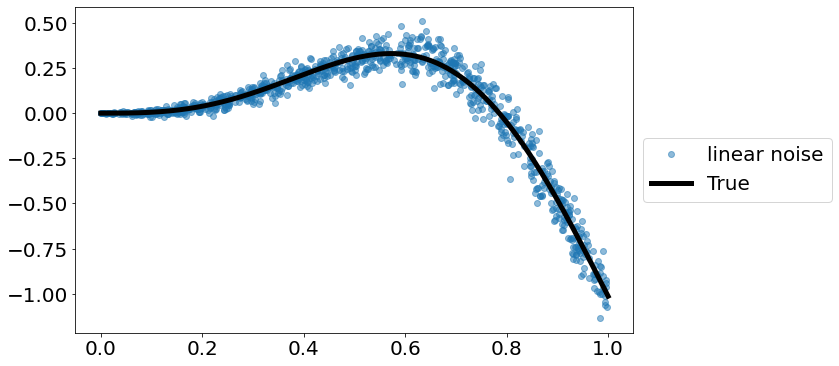

In [35]:

plt.plot(x_rng, y_linear_rng, 'o', label='linear noise', alpha=0.5)

    
plt.plot(x, y, label='True', c='k', lw=5)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

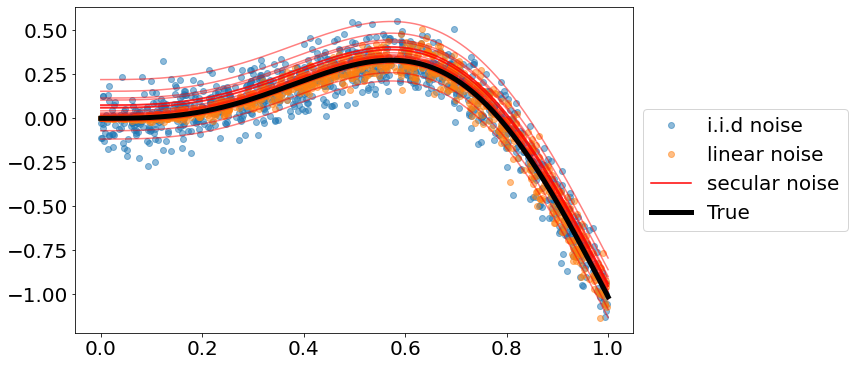

In [36]:

plt.plot(x_rng, y_rng, 'o', label='i.i.d noise', alpha=0.5)
plt.plot(x_rng, y_linear_rng, 'o', label='linear noise', alpha=0.5)

plt.plot(x, y_sec_rngs[0], '-', label='secular noise', c='r')
for y_sec_rng in y_sec_rngs[1:]:
    plt.plot(x, y_sec_rng, '-', c='r', alpha=0.5)
    
plt.plot(x, y, label='True', c='k', lw=5)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [37]:

plt.plot(x_rng, y_rng, 'o', label='i.i.d noise', alpha=0.5)
plt.plot(x_rng, y_linear_rng, 'o', label='linear noise', alpha=0.5)

plt.fill_between(x, y1=np.min(y_sec_rngs,0), y2=np.max(y_sec_rngs, 0), color='r', alpha=0.5, label='secular noise')
    
plt.plot(x, y, label='True', c='k', lw=5)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [38]:
for y_sec_rng in y_sec_rngs:
    plt.plot(x, y - y_sec_rng)
plt.title('Error between true and secular is constant')

Text(0.5, 1.0, 'Error between true and secular is constant')

In [39]:

# Define the probabilistic model...
# A simple prior:
bounds = [(-20, 20), (-20, 20), (-10, -0.1)]

In [40]:
import linear_emcee

In [41]:
x.shape

(1000,)

In [42]:
y.shape

(1000,)

In [43]:
# def ansatz(theta, x):
#     return theta[0]*x + theta[1]

def ansatz(theta, x):
    return theta[0]*x**2 * np.sin(theta[1]*x)

f_ = lambda x, t0, t1: ansatz([t0,t1], x)

In [44]:



log_likelihood_func = lambda theta, x, y: linear_emcee.log_likelihood(theta, x, y, ansatz)
# log_likelihood_func = lambda theta, x, y: linear_emcee.log_likelihood_scaled_noise(theta, x, y, ansatz)


log_prior_func = lambda p: linear_emcee.log_prior(p, bounds)
log_prob_func = lambda theta, x, y: linear_emcee.log_probability(theta, x, y, log_prior_func, log_likelihood_func)

In [45]:
p0_dist = lambda n_samples: np.random.uniform(-10, 10, (n_samples, 2))

In [46]:
p0_dist(1)

array([[-5.28420633, -8.03876911]])

In [47]:
sampler, popt = linear_emcee.run_sampler(x_rng, y_rng, f_, ansatz, log_prob_func, nsteps=10000, p0_dist=p0_dist, ntries=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1408.34it/s]


In [48]:
popt

array([1.34561841, 4.01368662])

In [49]:
plt.plot(x, ansatz(popt, x))

In [50]:
sampler

In [51]:

samples = sampler.get_chain()
ndim = samples.shape[2]

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

labels = ["m", "b", "log(f)"]
# labels = ["m", "b", "log(f)", 'log(noise_m)']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [52]:
tau = sampler.get_autocorr_time()
print(tau)

[35.34882734 32.99554547 70.74342784]


In [53]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
print(flat_samples.shape)

(25600, 3)


In [54]:
np.log(noise_sd_true)

-2.3025850929940455

In [55]:
beta0_true, beta1_true, np.log(noise_sd_true)

(1.34, 4.0, -2.3025850929940455)

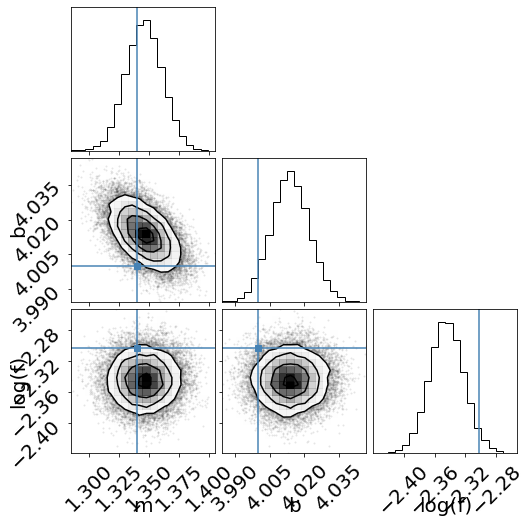

In [56]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[beta0_true, beta1_true, np.log(noise_sd_true)]
);

In [57]:
yhats = []
for sample in flat_samples[:100]:
    # yhat = sample[0]*x + sample[1]
    yhat = ansatz(sample, x)
    noise = np.random.normal(0, np.exp(sample[2]))
    yhats.append(yhat + noise)
yhats = np.array(yhats)

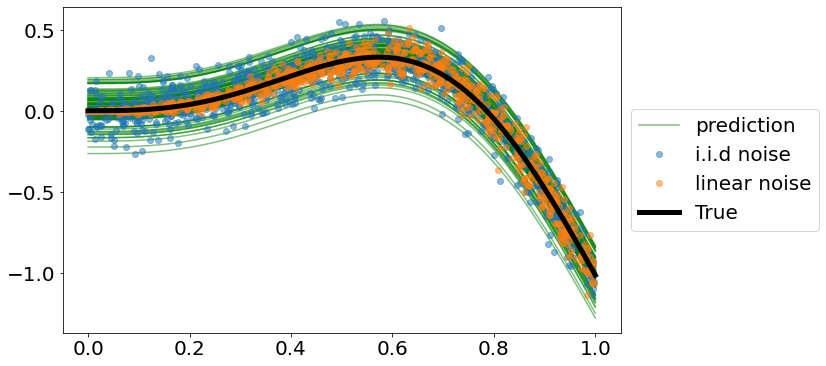

In [58]:
plt.plot(x, yhats[0], label='prediction', color='g', alpha=0.5)
for y_ in yhats[1:]:
    plt.plot(x, y_, color='g', alpha=0.5)
    
plt.plot(x_rng, y_rng, 'o', label='i.i.d noise', alpha=0.5)
plt.plot(x_rng, y_linear_rng, 'o', label='linear noise', alpha=0.5)
plt.plot(x, y, label='True', c='k', lw=5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))